In [1]:
import numpy as np
import struct
import os
import tensorflow as tf
import matplotlib.pyplot as plt

/home/luke/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class MNIST_GAN():
    def __init__(self, directory):
        self._directory = directory
        
        self._data = self._load_binaries("train-images.idx3-ubyte")
        self._data = np.append(self._data, self._load_binaries("t10k-images.idx3-ubyte"), axis = 0)
        self._data = ((self._data / 255) * 2) - 1
        self._data = self._data.reshape([-1, 28, 28, 1])

    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    def get_batch(self, batch_size):
        samples_n = self._data.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
            
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = self._data[random_indices]
        
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]


In [3]:
# load the mnist data
mnist_data = MNIST_GAN('/home/luke/data/mnist/')

In [4]:
def feed_forward_layer(x, target_size, normalize = False, activation_function = None):
    print("Forward-Layer:" + str(x.shape))
    
    fan_in = int(x.shape[-1])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)
    
    activation = tf.matmul(x, weights) + biases
    
    if normalize:
        activation = batch_norm(activation, [0])
    
    return activation_function(activation) if callable(activation_function) else activation


def conv_layer(x, kernel_quantity, kernel_size, stride_size, normalize = False, activation_function = False):
    print("Conv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])
    
    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, depth, kernel_quantity], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer = var_init)
    
    activation = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    
    if normalize:
        activation = batch_norm(activation, [0, 1, 2])
    
    return activation_function(activation) if callable(activation_function) else activation


def back_conv_layer(x, target_shape, kernel_size, stride_size, normalize = False, activation_function = False):
    print("Back-Conv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    kernel_quantity = target_shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])
    
    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, kernel_quantity, depth], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer = var_init)
    
    activation = tf.nn.conv2d_transpose(
                                x, kernels,
                                output_shape = target_shape,
                                strides = [1, stride_size, stride_size, 1], 
                                padding = "SAME"
                ) 
    activation = activation + biases
    
    if normalize:
        activation = batch_norm(activation, [0, 1, 2])
    
    return activation_function(activation) if callable(activation_function) else activation



def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def _pop_batch_norm(x, pop_mean, pop_var, offset, scale):
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)

def _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale):
    decay = 0.99
    
    dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
    dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

    with tf.control_dependencies([dependency_1, dependency_2]):
        return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

def batch_norm(x, axes):
    depth = x.shape[-1]
    mean, var = tf.nn.moments(x, axes = axes)
    
    var_init = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [depth], tf.float32, var_init)
    var_init = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [depth], tf.float32, var_init)
    
    pop_mean = tf.get_variable("pop_mean", [depth], initializer = tf.zeros_initializer(), trainable = False)
    pop_var = tf.get_variable("pop_var", [depth], initializer = tf.ones_initializer(), trainable = False)
    
    return tf.cond(
        is_training,
        lambda: _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
        lambda: _pop_batch_norm(x, pop_mean, pop_var, offset, scale)
    )

def generate_random_vector(shape):
    return np.random.uniform(-1, 1, shape)


In [28]:
# constructing the dataflow graph 

tf.reset_default_graph()



# GENERATOR INPUT

random_vector_ph = tf.placeholder(tf.float32, shape=[32,50])
is_training = tf.placeholder_with_default(True, shape=[])


# GENERATOR

with tf.variable_scope('Generator_Layer_1'):
    gen_layer_1 = feed_forward_layer(
                            x = random_vector_ph,
                            target_size = 64*4*4,
                            normalize = True,
                            activation_function = tf.nn.relu
                  )
    gen_layer_1 = tf.reshape(gen_layer_1, shape=(32,4,4,64) )
    
with tf.variable_scope('Generator_Layer_2'):
    gen_layer_2 = back_conv_layer(
                            x = gen_layer_1,
                            target_shape = [32,7,7,32],
                            kernel_size = 5,
                            stride_size = 2,
                            normalize = True,
                            activation_function = tf.nn.relu
                  )
    
    
with tf.variable_scope('Generator_Layer_3'):
    gen_layer_3 = back_conv_layer(
                            x = gen_layer_2,
                            target_shape = [32,14,14,16],
                            kernel_size = 5,
                            stride_size = 2,
                            normalize = True,
                            activation_function = tf.nn.relu
                  )
    

with tf.variable_scope('Generator_Layer_4'):
    gen_layer_4 = back_conv_layer(
                            x = gen_layer_3,
                            target_shape = [32,28,28,1],
                            kernel_size = 5,
                            stride_size = 2,
                            normalize = False,
                            activation_function = tf.nn.tanh
                  )
    

    
# DISCRIMINATOR INPUT

real_images_ph = tf.placeholder(tf.float32, shape = [32, 28, 28, 1])
discriminator_batch = tf.concat([gen_layer_4, real_images_ph], axis=0)


# DISCRIMINATOR

with tf.variable_scope('Discriminator_Layer_1'):
    disc_layer_1 = conv_layer(
                            x = discriminator_batch,
                            kernel_quantity = 8,
                            kernel_size = 5,
                            stride_size = 2,
                            normalize = True,
                            activation_function = tf.nn.leaky_relu
    )
    
with tf.variable_scope('Discriminator_Layer_2'):
    disc_layer_2 = conv_layer(
                            x = disc_layer_1,
                            kernel_quantity = 16,
                            kernel_size = 5,
                            stride_size = 2,
                            normalize = True,
                            activation_function = tf.nn.leaky_relu
    )
    
with tf.variable_scope('Discriminator_Layer_3'):
    disc_layer_3 = conv_layer(
                            x = disc_layer_2,
                            kernel_quantity = 32,
                            kernel_size = 5,
                            stride_size = 2,
                            normalize = True,
                            activation_function = tf.nn.leaky_relu
    )
    
    
with tf.variable_scope('Discriminator_Read_Out'):
    flattened_disc_layer_3 = flatten(disc_layer_3)
    real_or_fake_logits = feed_forward_layer(
                            x = flattened_disc_layer_3,
                            target_size = 1,
                            normalize = False,
                            activation_function = None
                  )
    
    

with tf.variable_scope('Loss'):
        real_or_fake_labels = tf.concat([tf.constant(0.0, shape=[32,1]), tf.constant(1.0, shape=[32,1])],0)
        dis_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                                    labels = real_or_fake_labels,
                                    logits = real_or_fake_logits
                    )
        gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(
                                    labels = real_or_fake_labels[32:],
                                    logits = real_or_fake_logits[:32]
                    )

        
        dis_loss = tf.reduce_mean(dis_loss)
        gen_loss = tf.reduce_mean(gen_loss)
        
        tf.summary.scalar("Distinguisher_Loss", dis_loss)
        tf.summary.scalar("Generator_Loss", gen_loss)
        
    
        

with tf.variable_scope('Training'):
        trainable_variables = tf.trainable_variables()
        
        dis_variables = [var for var in trainable_variables if "Discriminator" in var.name]
        gen_variables = [var for var in trainable_variables if "Generator" in var.name]
        
        dis_optimizer = tf.train.AdamOptimizer(learning_rate=0.0004, beta1 = 0.5)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate=0.0004, beta1 = 0.5)
        
        
        dis_training_step = dis_optimizer.minimize(
                                    dis_loss, 
                                    var_list = dis_variables
                            )
        gen_training_step = gen_optimizer.minimize(
                                    gen_loss, 
                                    var_list = gen_variables
                            )



merged_summaries = tf.summary.merge_all()




    
    



    


Forward-Layer:(32, 50)
Back-Conv-Layer:(32, 4, 4, 64)
Back-Conv-Layer:(32, 7, 7, 32)
Back-Conv-Layer:(32, 14, 14, 16)
Conv-Layer:(64, 28, 28, 1)
Conv-Layer:(64, 14, 14, 8)
Conv-Layer:(64, 7, 7, 16)
Forward-Layer:(64, 512)


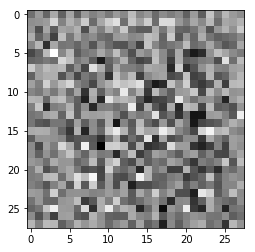

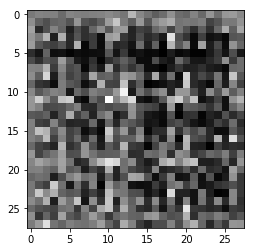

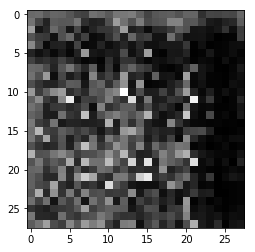

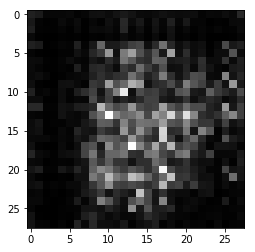

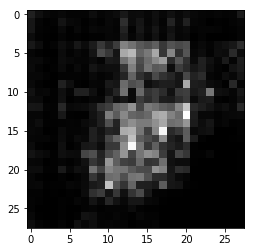

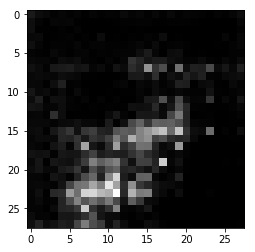

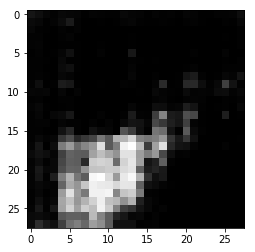

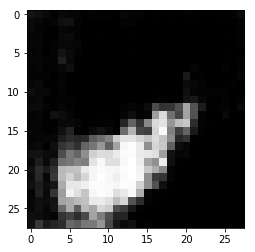

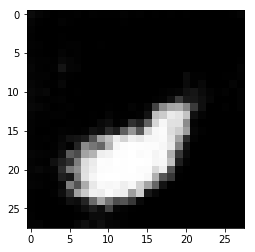

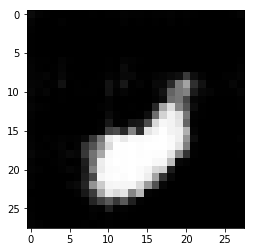

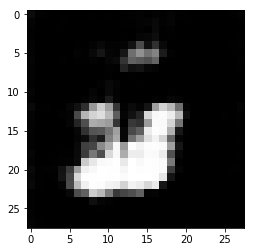

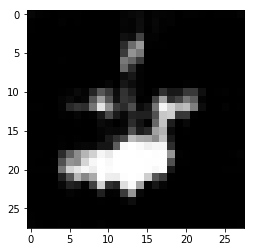

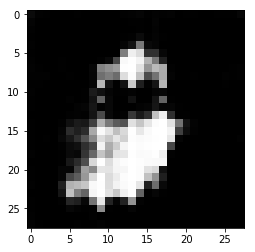

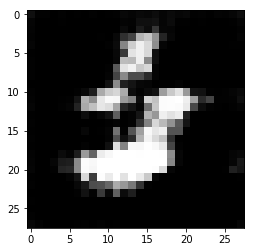

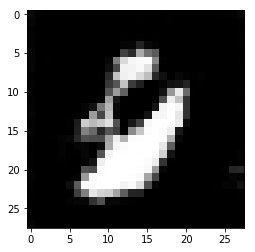

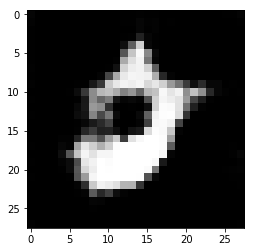

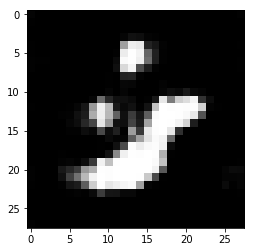

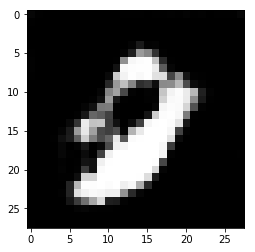

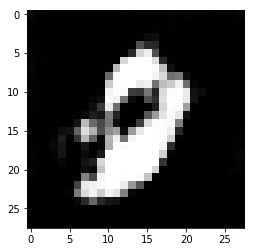

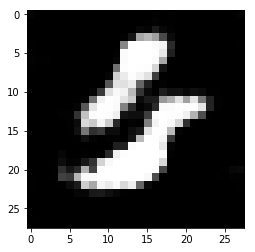

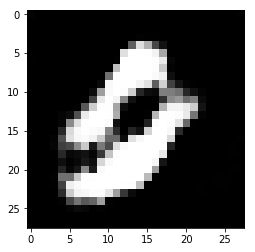

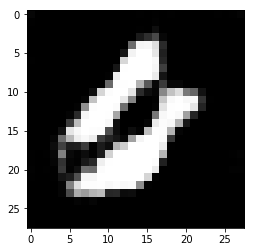

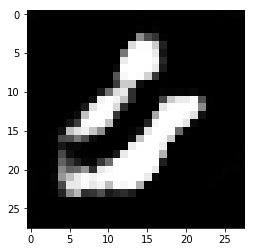

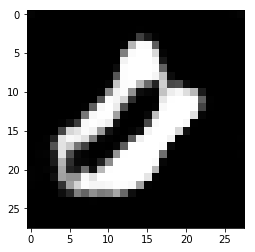

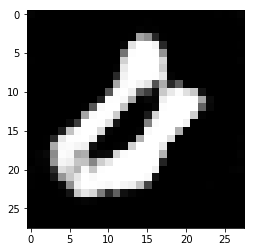

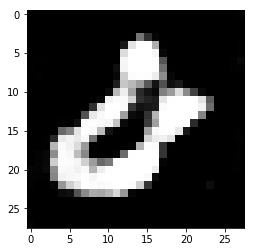

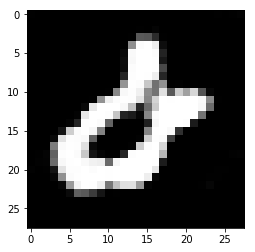

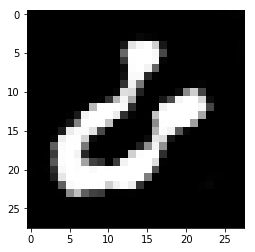

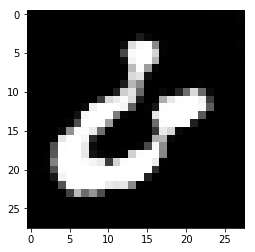

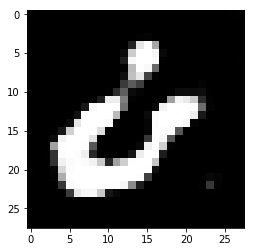

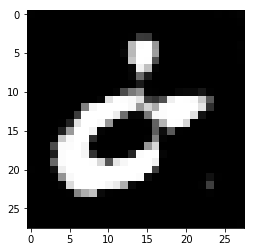

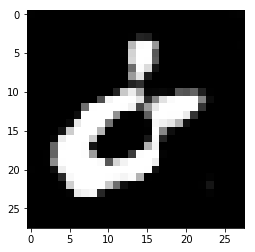

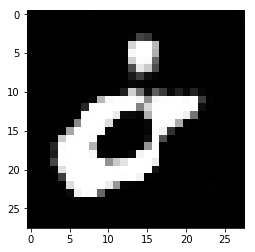

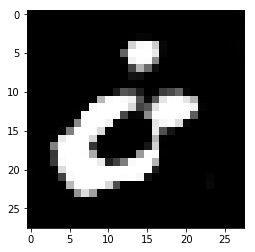

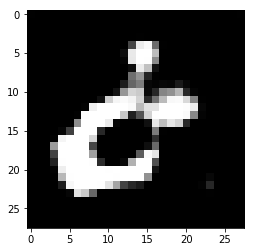

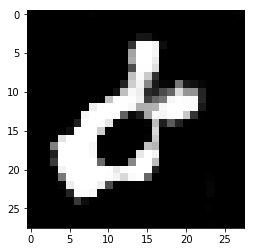

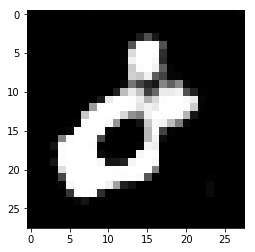

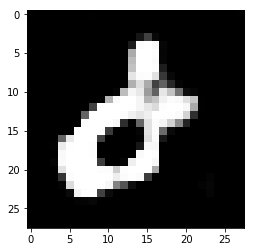

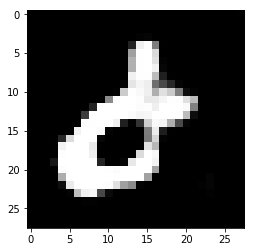

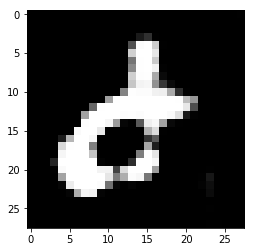

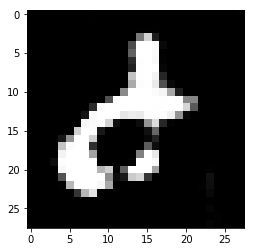

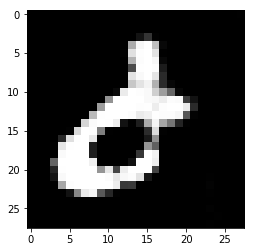

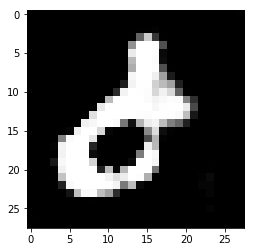

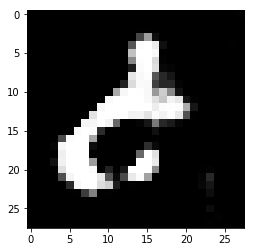

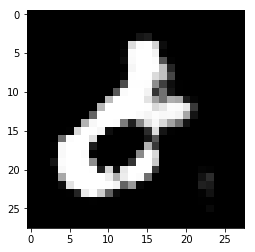

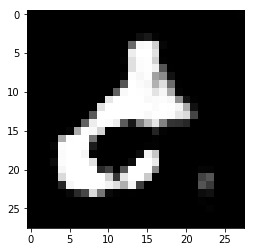

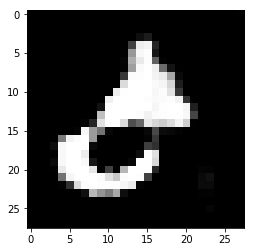

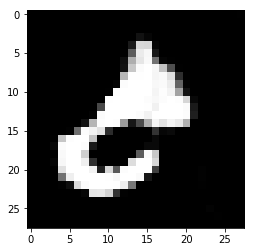

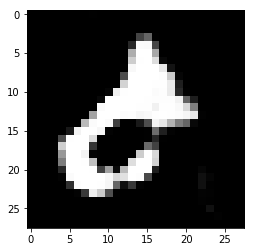

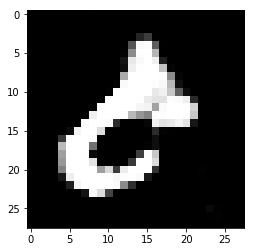

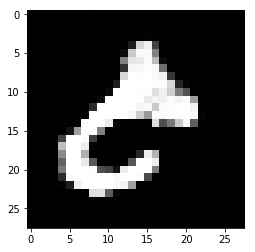

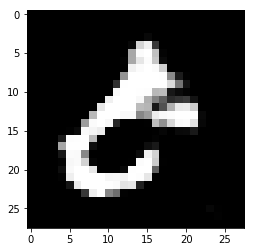

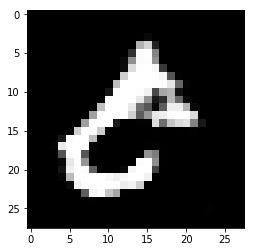

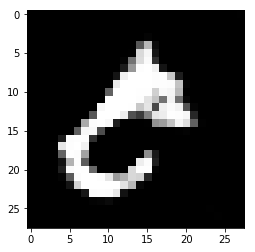

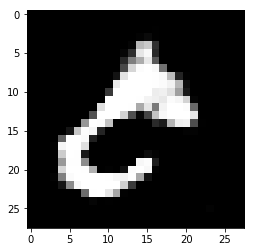

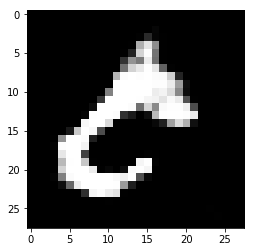

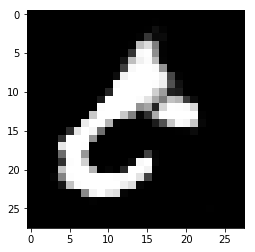

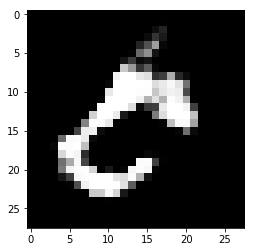

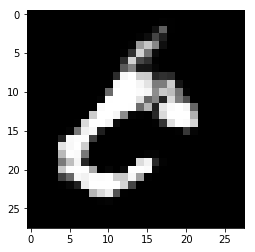

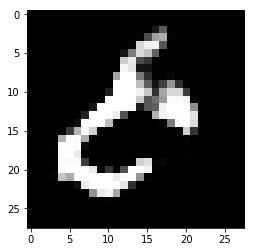

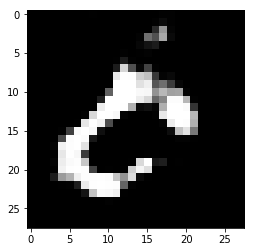

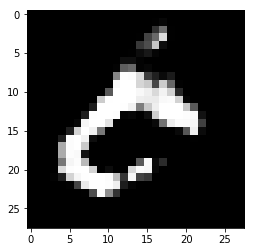

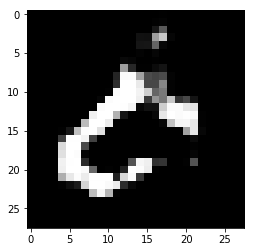

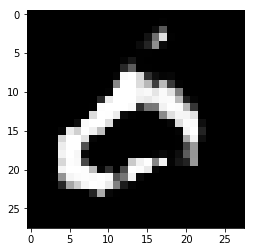

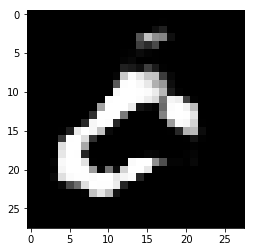

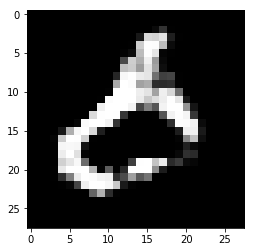

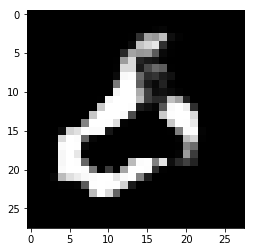

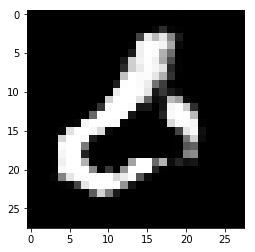

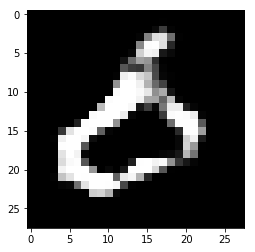

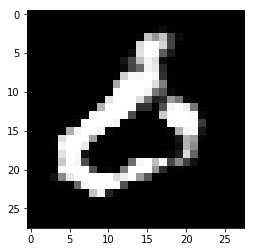

KeyboardInterrupt: 

In [29]:
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0
    
    validation_z = generate_random_vector(shape=(32,50))
    
    for epoch in range(2):
        
        batch_generator = mnist_data.get_batch(32)
        
        for batch in batch_generator:
            z = generate_random_vector(shape=(32, 50))
            _summaries, _, _ = sess.run(
                        [merged_summaries,
                         dis_training_step,
                         gen_training_step],
                         feed_dict = {
                            random_vector_ph: z,
                            real_images_ph: batch
                          }
                         )
            
            train_writer.add_summary(_summaries, step)
                
                
            if(step%30==0):  
                
                validation_img = sess.run([gen_layer_4],
                                         feed_dict = {
                                             random_vector_ph: validation_z
                                         })
                
                #print(validation_img[1].shape)
                plt.imshow(validation_img[0][0,:,:,0], cmap='gray')
                plt.show()
            
            step += 1
        